# GMM method analysis and final errors for DS-ID

In [ ]:
NOTEBOOK_CONFIG = {'IMG_LENGTH': 0.377,
                   'IMG_WIDTH': 0.143,
                   'IMG_XDIM': 143,
                   'IMG_YDIM': 377,
                   'labels_type' : "Labelsv0_detect",
                   'task' : "detect",
                   'model_name' : 'YOLOv0_E4_detect'}

In [2]:
# Sample image
n_image = 601
image_path = f"../docs/Data/Images/gaussian_{n_image}.png"
label_path = f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
import pandas as pd
import numpy as np

from datetime import datetime

from matplotlib import pyplot as plt

In [6]:
from scipy.ndimage import laplace
import scipy.io

from skimage.feature import peak_local_max
from adjustText import adjust_text

In [7]:
from PIL import Image

# Load modules

In [14]:
import sys
sys.path.append("..")

    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time} seconds")
        return result



In [ ]:
from helpers.auxiliary_functions import (generate_grid,
                                         parameters_extract,
                                         checkpoint_error)
from helpers.aux_plotter import (plot_boxes_gmm,
                                 gaussians_labelled,
                                 plot_grayscale)
from helpers.gaussian_estimation import (sum_gaussians,
                                         compute_mse)

from pipelines.pipelines import (ppl_fit_gaussians,
                                 ppl_error_estimation)

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [15]:
# Load 400 gaussians
mat = scipy.io.loadmat('../Data/db_80beam.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [16]:
# Generate GRID
x, y = generate_grid((0, NOTEBOOK_CONFIG['IMG_WIDTH']), 
                     (0, NOTEBOOK_CONFIG['IMG_LENGTH']), 
                     NOTEBOOK_CONFIG['IMG_XDIM'],
                     NOTEBOOK_CONFIG['IMG_YDIM'])

## Box of the gaussians - using dispersion_x and dispersion_y (from true parameters)

In [ ]:
# Load data
# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Structure covariances
covariances = [np.diag(cov) for cov in zip((dispersion_x/np.sqrt(2))**2, 
                                           (dispersion_y/np.sqrt(2))**2)]

Number of indentifiable Gaussians (center in the image): 77


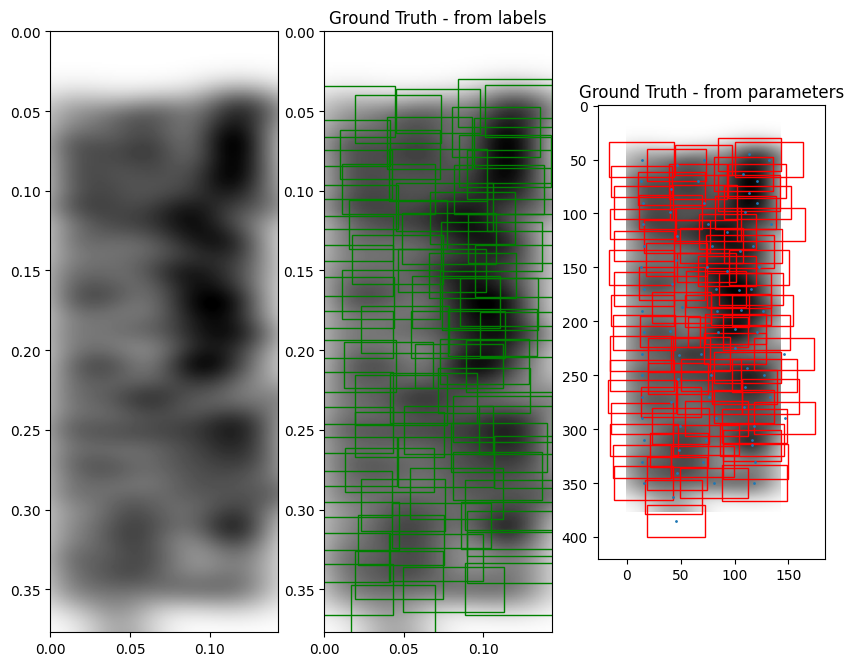

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize = (10, 10))

# Display the image
axs[2].imshow(im)
plot_boxes_gmm(means = list(zip(xs, ys)),
               covariances = covariances,
               ax = axs[2],
               beta = 3)
axs[2].set_title("Ground Truth - from parameters")
axs[2].scatter(xs * 1000, ys * 1000, s = 1)

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = NOTEBOOK_CONFIG['task'],
                   colorbar = False)
axs[1].set_title("Ground Truth - from labels")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[2].set_xlim(0, NOTEBOOK_CONFIG['IMG_XDIM'])
axs[2].set_ylim(0, NOTEBOOK_CONFIG['IMG_YDIM'])
axs[2].invert_yaxis()

for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

# [ESTIMATION PART IV]
- Images: 400 - 599
  -  All amplitudes are higher around 2.1E6 (400%)
  - x center coincides with beta xs
  - y center Coincides with beta ys
  - dispersion in x Higher dispersion in x direction around 0.017 (170%)
  - dispersion in y Higher dispersion in y direction around 0.01 (170%)


## [ESTIMATION] Pipeline ppl_SCIKIT_GMM
- Processing using Scikit-image library
- Mean and covariances from GMM

In [17]:
# Load data
# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

### Centers estimation

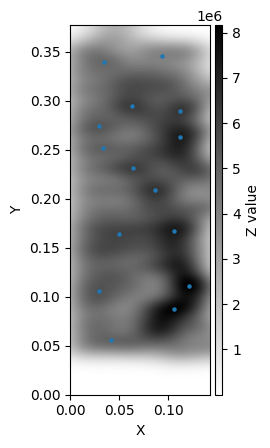

In [18]:
# Find local maxima coordinates
coordinates = peak_local_max(image[2], min_distance = 1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s = 5)

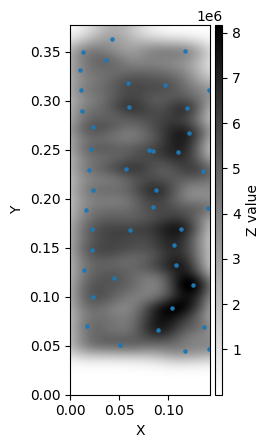

In [19]:
# Find local maxima coordinates
z_laplace = laplace(image[2])
z_laplace[np.nonzero(z_laplace >= 0)] = 0
coordinates = peak_local_max(-1 * z_laplace, min_distance = 1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s = 5)

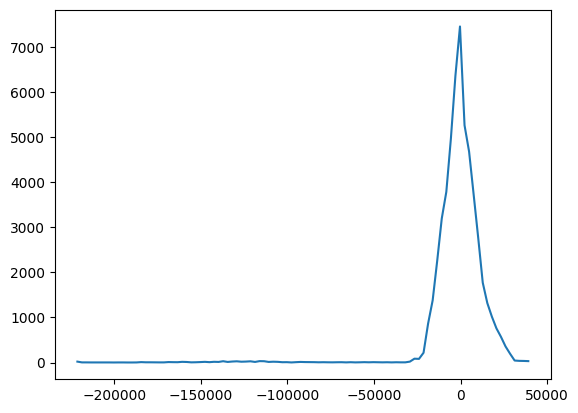

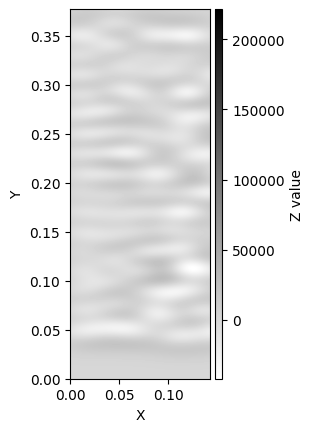

In [20]:
# Thresholding laplacian
# histogram of values
histogram, bin_edges = np.histogram(-1 * laplace(image[2]), bins = 100)

fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)

fig, ax = plt.subplots()
plot_grayscale(x, y, laplace(image[2]), ax)

estimate_parameters_gmm executed in 5.294665336608887 seconds
ppl_fit_gaussians executed in 5.820713758468628 seconds


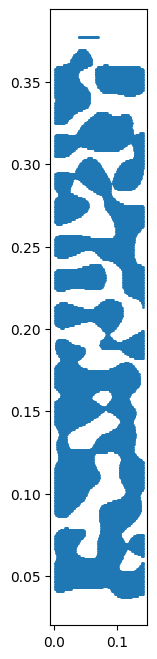

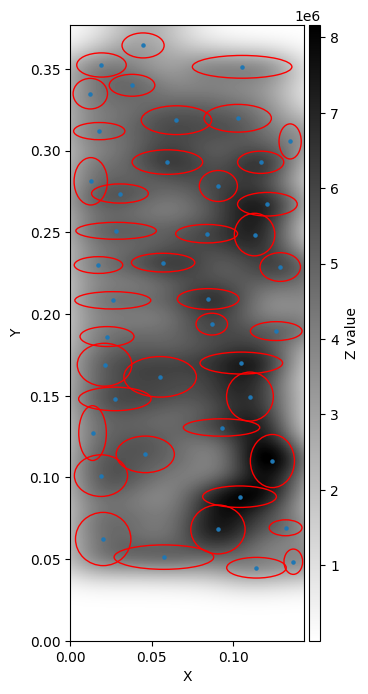

In [21]:
# Estimate Gaussian - Final prediction
(means,
 covariances,
 angles,
 amplitudes) = ppl_fit_gaussians(image,
                                 means_init = 'laplace',
                                 peak_method = 'laplace',
                                 em_iterations = 1000,
                                 covariance_gaussians_type = 'diag',
                                 n_gaussians = None,
                                 image_ranges = [(0, NOTEBOOK_CONFIG['IMG_WIDTH']), 
                                                 (0, NOTEBOOK_CONFIG['IMG_LENGTH'])],
                                 image_size = [NOTEBOOK_CONFIG['IMG_XDIM'], 
                                               NOTEBOOK_CONFIG['IMG_YDIM']],
                                 fig_size = (10, 8),
                                 plot = True,
                                 plot_points = True)

Number of indentifiable Gaussians (center in the image): 76


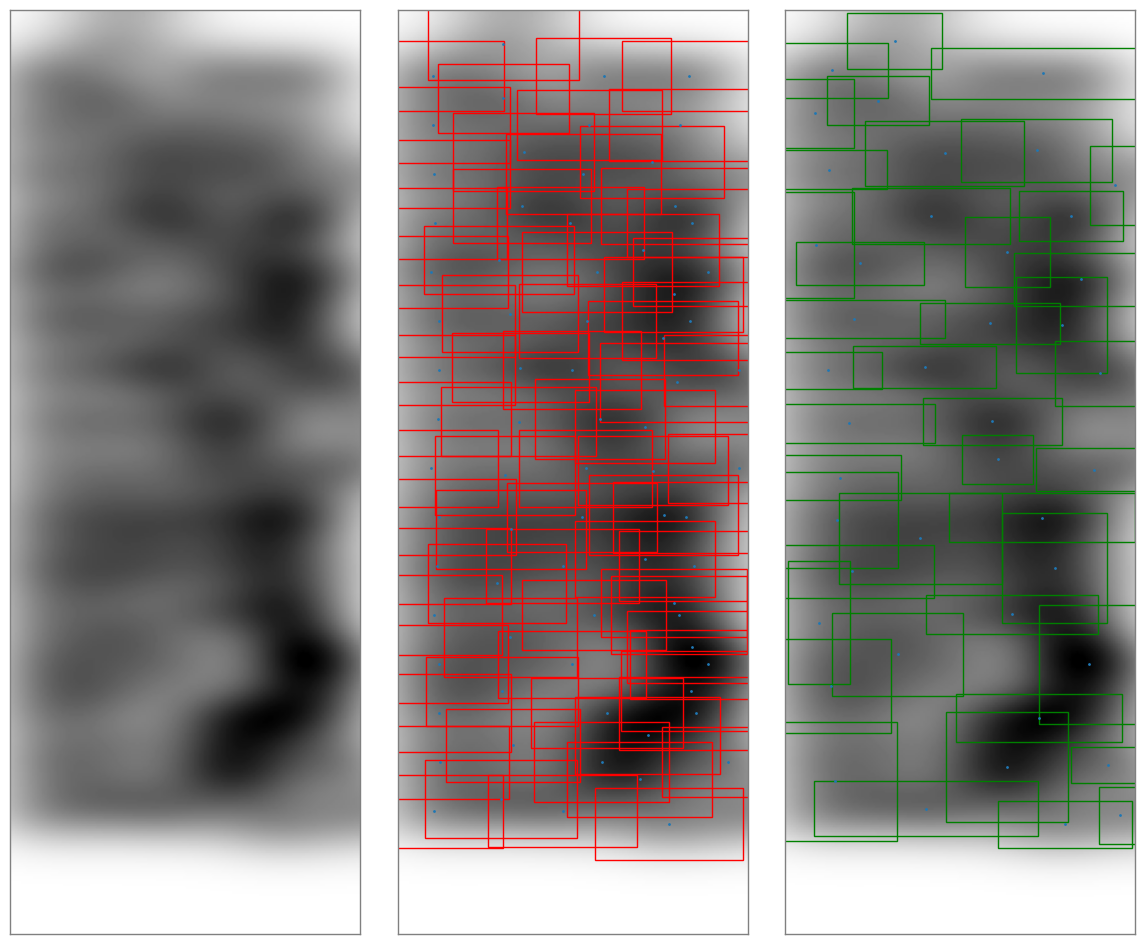

In [23]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize = (15, 12))

# Display the image and plot predicted centers
axs[2].imshow(im)
plot_boxes_gmm(means = means,
               covariances = covariances,
               ax = axs[2],
               beta = 3,
               edge_color = 'g')
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:,0] * 1000, means[:, 1] * 1000, s = 1)
# axs[2].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG['IMG_XDIM'])
axs[2].set_ylim(0, NOTEBOOK_CONFIG['IMG_YDIM'])

#axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = NOTEBOOK_CONFIG['task'],
                   colorbar = False,
                   plot_centers = True)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG['IMG_WIDTH'])
axs[1].set_ylim(0, NOTEBOOK_CONFIG['IMG_LENGTH'])
#axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG['IMG_WIDTH'])
axs[0].set_ylim(0, NOTEBOOK_CONFIG['IMG_LENGTH'])


for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

  ax.set_xticks([])
  ax.set_yticks([])
  # Change the color of the axis spines (borders)
  for spine in ax.spines.values():
      spine.set_edgecolor('gray')
      spine.set_linewidth(1)

plt.subplots_adjust(wspace= 0)
plt.show()

### Error evaluation
- Dispersion_x in the mat file is equal to sqrt(2) * sigma_x, same for y direction

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[738, 777, 650, 772, 703, 704, 726, 710, 601, 622, 664, 694, 690, 700, 605, 719, 614, 603, 766, 714]


In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - gmm' : [],
           'Number identifiable - gmm' : [],
           'Percentage - gmm' : [],
           'RMSE_cx - gmm' : [],
           'RMSE_cy - gmm' : [],
           'RMSE_c - gmm' : [],
           'RMSE_sigmax - gmm' : [],
           'RMSE_sigmay - gmm' : [],
           'RMSE_sigma - gmm' : [],
           'RMSE_amplitude - gmm': [],
           'MaxE_sigmax - gmm': [],
           'MaxE_sigmay - gmm': [],
           'MaxE_sigma - gmm': [],
           'RMSE_amplitude - gmm': [],
           'RMSEPixel - gmm': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       peak_method = 'laplace',
                                       estimation_method = "gmm",
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]

estimate_parameters_gmm executed in 2.0332608222961426 seconds
ppl_fit_gaussians executed in 2.061185598373413 seconds
covariances [[[0.02651083 0.        ]
  [0.         0.00659401]]]
covariances true [[[0.02510648 0.        ]
  [0.         0.0138926 ]]]
estimate_parameters_gmm executed in 2.661756992340088 seconds
ppl_fit_gaussians executed in 2.674081802368164 seconds
covariances [[[0.02402768 0.        ]
  [0.         0.00702851]]]
covariances true [[[0.02541002 0.        ]
  [0.         0.01341907]]]
estimate_parameters_gmm executed in 5.124617099761963 seconds
ppl_fit_gaussians executed in 5.1583168506622314 seconds
covariances [[[0.02228426 0.        ]
  [0.         0.00851676]]]
covariances true [[[0.02874664 0.        ]
  [0.         0.01516224]]]
estimate_parameters_gmm executed in 5.335970878601074 seconds
ppl_fit_gaussians executed in 5.369339942932129 seconds
covariances [[[0.02358087 0.        ]
  [0.         0.00766723]]]
covariances true [[[0.02922224 0.        ]
  [0. 

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,688.60,56.81,777.00
Number identified - gmm,43.10,2.55,48.00
Number identifiable - gmm,75.30,1.42,77.00
Percentage - gmm,57.27,3.71,64.86
RMSE_cx - gmm,13.29,2.28,17.01
RMSE_cy - gmm,2.30,0.34,3.06
RMSE_c - gmm,13.50,2.24,17.18
RMSE_sigmax - gmm,41.66,2.08,46.72
RMSE_sigmay - gmm,41.76,3.23,48.50
RMSE_sigma - gmm,59.06,2.49,62.77


In [ ]:
pd.DataFrame.from_dict(results).round(2)

,Image,Number identified - gmm,Number identifiable - gmm,Percentage - gmm,RMSE_cx - gmm,RMSE_cy - gmm,RMSE_c - gmm,RMSE_sigmax - gmm,RMSE_sigmay - gmm,RMSE_sigma - gmm,RMSE_amplitude - gmm,MaxE_sigmax - gmm,MaxE_sigmay - gmm,MaxE_sigma - gmm,RMSEPixel - gmm
0,738,47,77,61.04,14.05,2.33,14.24,40.06,38.86,55.81,89.89,82.87,73.90,111.03,1252200.07
1,777,45,77,58.44,14.59,1.83,14.70,39.52,48.50,62.56,94.16,87.57,105.04,136.76,1181863.06
2,650,48,74,64.86,10.61,2.05,10.80,41.93,41.45,58.96,85.54,87.04,106.56,137.59,1181935.21
3,772,43,73,58.90,16.18,2.07,16.31,40.85,45.26,60.97,84.66,87.46,178.08,198.40,1237367.10
4,703,44,74,59.46,14.39,2.26,14.56,39.67,41.23,57.21,95.01,86.23,68.07,109.86,1222442.99
5,704,43,74,58.11,9.24,2.50,9.58,40.87,42.80,59.18,92.16,85.41,91.68,125.30,1239410.25
6,726,42,76,55.26,12.23,2.04,12.40,39.67,47.12,61.60,91.07,90.58,87.55,125.98,1190587.57
7,710,39,74,52.70,13.47,2.16,13.65,40.96,36.70,55.00,93.88,86.60,74.61,114.31,1144388.38
8,601,43,76,56.58,15.86,1.77,15.96,39.46,41.11,56.98,99.54,79.11,63.79,101.62,1222877.58
9,622,39,76,51.32,9.47,1.89,9.66,42.49,39.72,58.16,91.77,82.10,65.70,105.16,1139913.30


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {images_test}\n
                 id_estimation_method = {"GMM - random state 13 - first 200 images"}\n
                 id_images evaluated: {eval_images}""",
                 name = "E4GMM")

#### Total error

In [ ]:
# Computing error
gaussians = list(zip(means, covariances, amplitudes))

# Generate image from Gaussians and compute MSE
generated_image = sum_gaussians(x, y, gaussians)
mse = compute_mse(image[2], generated_image)